# TAIL-RISK FUND: OPTIONS

author: [@sparshsah](https://github.com/sparshsah)

ref: https://github.com/sparshsah/foggy-demo/blob/main/demo/finance/tail-risk-fund.md

In [87]:
from __future__ import annotations

import numpy as np
import pandas as pd

# https://github.com/sparshsah/foggy-statslib
import sys; sys.path.append("../../../foggy-statslib/")
import foggy_statslib.core as fsc
import foggy_statslib.fin as fsf

# EXPLORE

## Setting

You hold one share of S, which is currently trading at 100USD.
(S is SPX, but I don't want the fact that SPX is not tradable and also actually at 3000USD to distract you.)

You believe that it is equally likely to:
1. Fall 20pct over the next 6 months (accompanied by a doubling in ivols), Then stay flat to EOY
2. Stay flat over the next 6 months, Then fall 20pct by EOY
3. Stay flat through EOY

Prevailing option-implied vols are around 16pct,
and for simplicity neglect (a) volatility smirks, (b) the risk-free rate, and (c) tcosts.

Crucially: Unlike most single-name equity options which are American-style, the SPX-like index options we consider are European-style.

In [32]:
sigma: Final[float] = 0.16
r: Final[float] = 0

## Question

Should you
* A: Purchase a 2-quarter put (rolling into another one if the crash fails to materialize by expiry)?
* B: Purchase a 4-quarter put?
* C: Buy "half" of each strategy?

Assuming you fix your strike at 90USD.
Assume also that you finance your puts with borrowing (not selling shares).

In [48]:
init_value_of_one_put_a = fsf.calc_bsf_option_value(
    tau=2/4,
    K=90,
    S_t=100,
    sigma=sigma,
    r=r,
    put=True,
)
init_value_of_one_put_b = fsf.calc_bsf_option_value(
    tau=4/4,
    K=90,
    S_t=100,
    sigma=sigma,
    r=r,
    put=True,
)
print(f"Premium for each Put: A = ${init_value_of_one_put_a:.2f}, B = ${init_value_of_one_put_b:.2f}.")

Premium for each Put: A = $1.02, B = $2.32.


In [64]:
# dollar return under each scenario of different strategies, by quarter

# SCENARIO 1: S falls -20% over the next 6 months, then stays flat to EOY
r1 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: -20,
            3: 0,
            4: 0,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # you would exercise, earning $10
            2: +10,
            3: 0,
            4: 0,
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now more valuable! thanks to the price crash and associated vol spike.
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=80,  # down from 100
                    sigma=2*sigma,  # doubled
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # now there's no more activity, as you sold your put once you observed the crash
            3: 0,
            4: 0,
        },
    }
)
r1.loc[:, "c"] = r1[["a","b"]].mean(axis="columns")
r1.loc["=>", :] = r1.sum()


# SCENARIO 2: S stays flat over the next 6 months, then drops -20% by EOY
r2 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: -20,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            2: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # on top of that, you're back to the start: you must now buy a new one (financed with borrowing)
                # Notice: Nothing has changed about the market.
                + (init_value_of_one_put_a - init_value_of_one_put_a)
            ),
            3: (
                # your SECOND put is now again less valuable, as a quarter passes with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # sweet payoff
            4: +10,
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now EVEN less valuable, as ANOTHER quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # rinse and repeat
            3: (
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                - fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # sweet payoff
            4: +10,
        },
    }
)
r2.loc[:, "c"] = r2[["a","b"]].mean(axis="columns")
r2.loc["=>", :] = r2.sum()

# SCENARIO 3: S stays flat through EOY
r3 = pd.DataFrame(
    {
        # the shares
        "principal": {
            0: 0,
            1: 0,
            2: 0,
            3: 0,
            4: 0,
        },
        # the hedges
        # a: a 2-quarter put
        "a": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_a - init_value_of_one_put_a,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            2: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # on top of that, you're back to the start: you must now buy a new one (financed with borrowing)
                # Notice: Nothing has changed about the market.
                + (init_value_of_one_put_a - init_value_of_one_put_a)
            ),
            3: (
                # your SECOND put is now again less valuable, as a quarter passes with no market movements
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_a
            ),
            # sweet payoff
            4: (
                # your SECOND put is now again worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
        },
        # b: a 4-quarter put
        "b": {
            # you gained a put, but owe what you borrowed to buy it, so there's no net pnl
            0: init_value_of_one_put_b - init_value_of_one_put_b,
            1: (
                # your put is now less valuable, as a quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - init_value_of_one_put_b
            ),
            2: (
                # your put is now EVEN less valuable, as ANOTHER quarter has passed with no market movements
                fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                # we must diff vs what it was worth a quarter ago
                - fsf.calc_bsf_option_value(
                    tau=3/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            # rinse and repeat
            3: (
                fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
                - fsf.calc_bsf_option_value(
                    tau=2/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            ),
            4: (
                # your put is now worthless
                0 - fsf.calc_bsf_option_value(
                    tau=1/4,
                    K=90,
                    S_t=100,
                    sigma=sigma,
                    r=r,
                    put=True,
                )
            )
        },
    }
)
r3.loc[:, "c"] = r3[["a","b"]].mean(axis="columns")
r3.loc["=>", :] = r3.sum()

In [65]:
r1

,principal,a,b,c
0,0.0,0.00000,0.000000,0.000000
1,0.0,-0.68351,-0.629979,-0.656744
2,-20.0,10.00000,11.974178,10.987089
3,0.0,0.00000,0.000000,0.000000
4,0.0,0.00000,0.000000,0.000000
=>,-20.0,9.31649,11.344199,10.330345


In [66]:
r2

,principal,a,b,c
0,0.0,0.000000,0.000000,0.000000
1,0.0,-0.683510,-0.629979,-0.656744
2,0.0,-0.333041,-0.674634,-0.503837
3,0.0,-0.683510,-0.683510,-0.683510
4,-20.0,10.000000,10.000000,10.000000
=>,-20.0,8.299940,8.011877,8.155909


In [67]:
r3

,principal,a,b,c
0,0.0,0.000000,0.000000,0.000000
1,0.0,-0.683510,-0.629979,-0.656744
2,0.0,-0.333041,-0.674634,-0.503837
3,0.0,-0.683510,-0.683510,-0.683510
4,0.0,-0.333041,-0.333041,-0.333041
=>,0.0,-2.033100,-2.321164,-2.177132


In [68]:
# check: total should be equal to the accumulated option premia
2*init_value_of_one_put_a, init_value_of_one_put_b

(2.0331002120362314, 2.3211635243986244)

# BHANSALI

Trying Bhansali 2014's "active" strategy

In [174]:
NAV: Final[float] = 1e9
START_DATE: Final[str] = "2015-01-01"
MONEYNESS: Final[float] = -0.05
# annualized
_BUDGET: Final[float] = 0.01
# q'tly
BUDGET: Final[float] = NAV * _BUDGET / 4

In [149]:
def get_stock_px(ticker: str = "COF", start_date: str = START_DATE) -> pd.Series[float]:
    # underlying
    stock_px = pd.read_csv(
        f"data/yahoo-finance_NYSE-{ticker}_px.csv",
        index_col="Date",
        parse_dates=True,
    )["Adj Close"].rename("stock_px").loc[start_date:]
    dtx = pd.date_range(
        start=stock_px.index[0],
        end=stock_px.index[-1],
        freq="B",
        name="date",
    )
    stock_px = stock_px.reindex(index=dtx).ffill()
    return stock_px

def _get_r(stock_px: pd.Series[float]) -> pd.Series[float]:
    return stock_px/stock_px.shift() -1

def _get_vol(r: pd.Series[float], window: int = 65) -> pd.Series[float]:
    return (
        r
        .rolling(window=window, min_periods=round(0.95*window))
        .std()
        .ffill()
        # backfill the first `window` days... bc whatever
        .bfill()
    # annualize
    ) * 261**0.5

def get_ivol(stock_px: pd.Series[float], vrp_mult: float=1.05) -> pd.Series[float]:
    r = _get_r(stock_px=stock_px)
    vol = _get_vol(r=r)
    ivol = vrp_mult * vol
    return ivol

stock_px = get_stock_px()
ivol = get_ivol(stock_px=stock_px)

In [150]:
xdates = pd.date_range(
    start=stock_px.index[0],
    end=stock_px.index[-1],
    freq="BQ",
    name="expiration_dates",
)
assert not len(xdates.difference(stock_px.index)), xdates.difference(stock_px.index)
xdates

DatetimeIndex(['2015-03-31', '2015-06-30', '2015-09-30', '2015-12-31',
               '2016-03-31', '2016-06-30', '2016-09-30', '2016-12-30',
               '2017-03-31', '2017-06-30', '2017-09-29', '2017-12-29',
               '2018-03-30', '2018-06-29', '2018-09-28', '2018-12-31',
               '2019-03-29', '2019-06-28', '2019-09-30', '2019-12-31',
               '2020-03-31', '2020-06-30', '2020-09-30', '2020-12-31',
               '2021-03-31', '2021-06-30', '2021-09-30', '2021-12-31',
               '2022-03-31', '2022-06-30', '2022-09-30', '2022-12-30',
               '2023-03-31', '2023-06-30', '2023-09-29'],
              dtype='datetime64[ns]', name='expiration_dates', freq='BQ-DEC')

In [202]:
def _get_put_params(
    stock_px: pd.Series[float],
    ivol: pd.Series[float],
    xdates: pd.DatetimeIndex,
    moneyness: float = MONEYNESS,
) -> pd.Series[int]:
    params = pd.DataFrame({"stock_px": stock_px, "ivol": ivol})
    params.loc[:, "odate"] = pd.Series(index=xdates, data=xdates).reindex(index=stock_px.index).ffill()
    # fill in initial, but black out post-final
    params.loc[:xdates[0], "odate"] = stock_px.index[0]
    params.loc[xdates[-1]:, "odate"] = np.nan
    # expiration date
    params.loc[:, "xdate"] = pd.Series(index=xdates, data=xdates).reindex(index=stock_px.index).bfill()
    # SIMULATE IN-PRACTICE BEHAVIOR
    params.loc[:, "is_xdate"] = params.index.isin(xdates)
    params.loc[:, "is_rolldate"] = params["is_xdate"].shift(-1)
    # days to expiration
    params.loc[:, "dte"] = pd.Series(
        index=params["xdate"].dropna().index,
        data=np.busday_count(
            [
                d for d in
                params["xdate"].dropna().index.map(
                    lambda dt: dt.date()
                )
            ],
            [
                d for d in
                params["xdate"].dropna().map(
                    lambda dt: dt.date()
                )
            ],
        ),
    )
    # floor to make well-behaved at 0DTE
    params.loc[:, "yte"] = params["dte"].clip(lower=0.01)/261
    params.loc[:, "strike"] = stock_px.loc[xdates].reindex(index=stock_px.index).ffill() * (1+moneyness)
    # fill in initial, but black out post-final
    params.loc[:xdates[0], "strike"] = stock_px.iloc[0] * (1+moneyness)
    params.loc[xdates[-1]:, "strike"] = np.nan
    # ok whew
    params.loc[:, "put_value"] = params.apply(
        lambda row: fsf.calc_bsf_option_value(
            tau=row["yte"],
            K=row["strike"],
            S_t=row["stock_px"],
            sigma=row["ivol"],
            r=0.05,
            put=True,
        ),
        axis="columns",
    )
    params.loc[:, "upfront_premium"] = params["odate"].map(params["put_value"])
    params.loc[:, "period_cum_pnl"] = params["put_value"] - params["upfront_premium"]
    params.loc[:, "period_cum_pnl_if_rolldate"] = params["period_cum_pnl"] * params["is_rolldate"]
    params.loc[:, "n"] = BUDGET / params["upfront_premium"]
    return params

In [203]:
params = _get_put_params(stock_px,ivol, xdates)
params

,stock_px,ivol,odate,xdate,is_xdate,is_rolldate,dte,yte,strike,put_value,upfront_premium,period_cum_pnl,period_cum_pnl_if_rolldate,n
date,,,,,,,,,,,,,,
2015-01-02,69.560104,0.222506,2015-01-02,2015-03-31,False,False,62.0,0.237548,66.082099,1.267288,1.267288,0.000000,0.0,1.972717e+06
2015-01-05,67.957916,0.222506,2015-01-02,2015-03-31,False,False,61.0,0.233716,66.082099,1.728494,1.267288,0.461206,0.0,1.972717e+06
2015-01-06,66.693039,0.222506,2015-01-02,2015-03-31,False,False,60.0,0.229885,66.082099,2.177637,1.267288,0.910349,0.0,1.972717e+06
2015-01-07,67.451973,0.222506,2015-01-02,2015-03-31,False,False,59.0,0.226054,66.082099,1.870222,1.267288,0.602934,0.0,1.972717e+06
2015-01-08,68.109688,0.222506,2015-01-02,2015-03-31,False,False,58.0,0.222222,66.082099,1.625903,1.267288,0.358615,0.0,1.972717e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-27,106.180000,0.316925,NaT,NaT,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-28,108.580002,0.317938,NaT,NaT,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-11-29,110.129997,0.318379,NaT,NaT,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='date'>

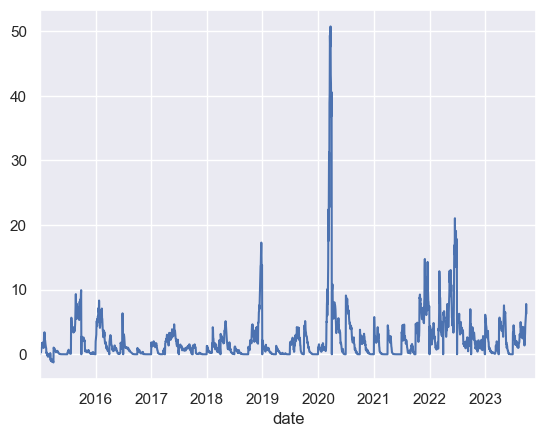

In [204]:
params["period_cum_pnl"].plot()

In [210]:
params.loc["2015-03-25":"2015-04-05"]

,stock_px,ivol,odate,xdate,is_xdate,is_rolldate,dte,yte,strike,put_value,upfront_premium,period_cum_pnl,period_cum_pnl_if_rolldate,n
date,,,,,,,,,,,,,,
2015-03-25,66.748154,0.222506,2015-01-02,2015-03-31,False,False,4.0,0.015326,66.082099,4.265160e-01,1.267288e+00,-0.840772,-0.0,1.972717e+06
2015-03-26,66.468773,0.222506,2015-01-02,2015-03-31,False,False,3.0,0.011494,66.082099,4.408350e-01,1.267288e+00,-0.826453,-0.0,1.972717e+06
2015-03-27,66.587280,0.222506,2015-01-02,2015-03-31,False,False,2.0,0.007663,66.082099,2.929502e-01,1.267288e+00,-0.974338,-0.0,1.972717e+06
2015-03-30,67.052933,0.222506,2015-01-02,2015-03-31,False,True,1.0,0.003831,66.082099,6.635470e-02,1.267288e+00,-1.200933,-1.200933,1.972717e+06
2015-03-31,66.731247,0.222506,2015-01-02,2015-03-31,True,False,0.0,0.000038,66.082099,7.799571e-15,1.267288e+00,-1.267288,-0.0,1.972717e+06
2015-04-01,67.620193,0.222696,2015-03-31,2015-06-30,False,False,64.0,0.245211,63.394685,1.030838e+00,7.799571e-15,1.030838,0.0,3.205305e+20
2015-04-02,67.992699,0.221273,2015-03-31,2015-06-30,False,False,63.0,0.241379,63.394685,9.215747e-01,7.799571e-15,0.921575,0.0,3.205305e+20
2015-04-03,67.992699,0.219538,2015-03-31,2015-06-30,False,False,62.0,0.237548,63.394685,8.911217e-01,7.799571e-15,0.891122,0.0,3.205305e+20


<Axes: xlabel='date'>

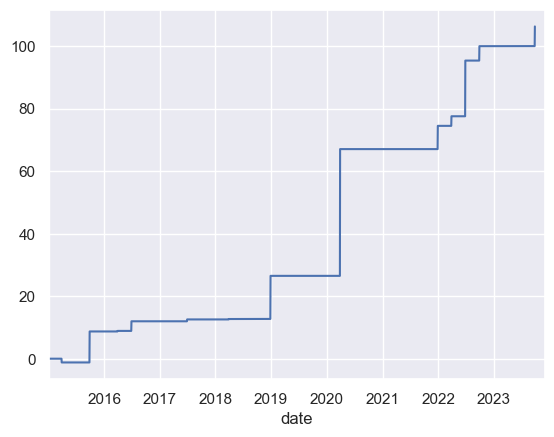

In [217]:
params["period_cum_pnl_if_rolldate"].cumsum().plot()